In [101]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from imblearn.under_sampling import RandomUnderSampler

# Model Building
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV # parameter tuning

from imblearn.under_sampling import RandomUnderSampler # unbalanced dataset
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector # feature selection
from sklearn.model_selection import cross_validate, cross_val_score, KFold

# Additional models
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier

In [65]:
# Read in data
df = pd.read_csv('stroke data.csv')
df.head()

,id,gender,age,married,hypertension,heart_disease,occupation,residence,metric_1,metric_2,metric_3,metric_4,metric_5,smoking_status,stroke
0,1,Male,3.0,No,0,0,A,Rural,95.12,18.0,1,99.35,95.12,NaN,0
1,2,Male,58.0,Yes,1,0,B,Urban,87.96,39.2,1,99.70,87.96,never smoked,0
2,3,Female,8.0,No,0,0,B,Urban,110.89,17.6,0,96.35,110.89,NaN,0
3,4,Female,70.0,Yes,0,0,B,Rural,69.04,35.9,0,95.52,69.04,formerly smoked,0
4,5,Male,14.0,No,0,0,C,Rural,161.28,19.1,1,95.10,161.28,NaN,0


### EDA

In [66]:
df = df[~df.isnull()] # remove rows with all NaNs

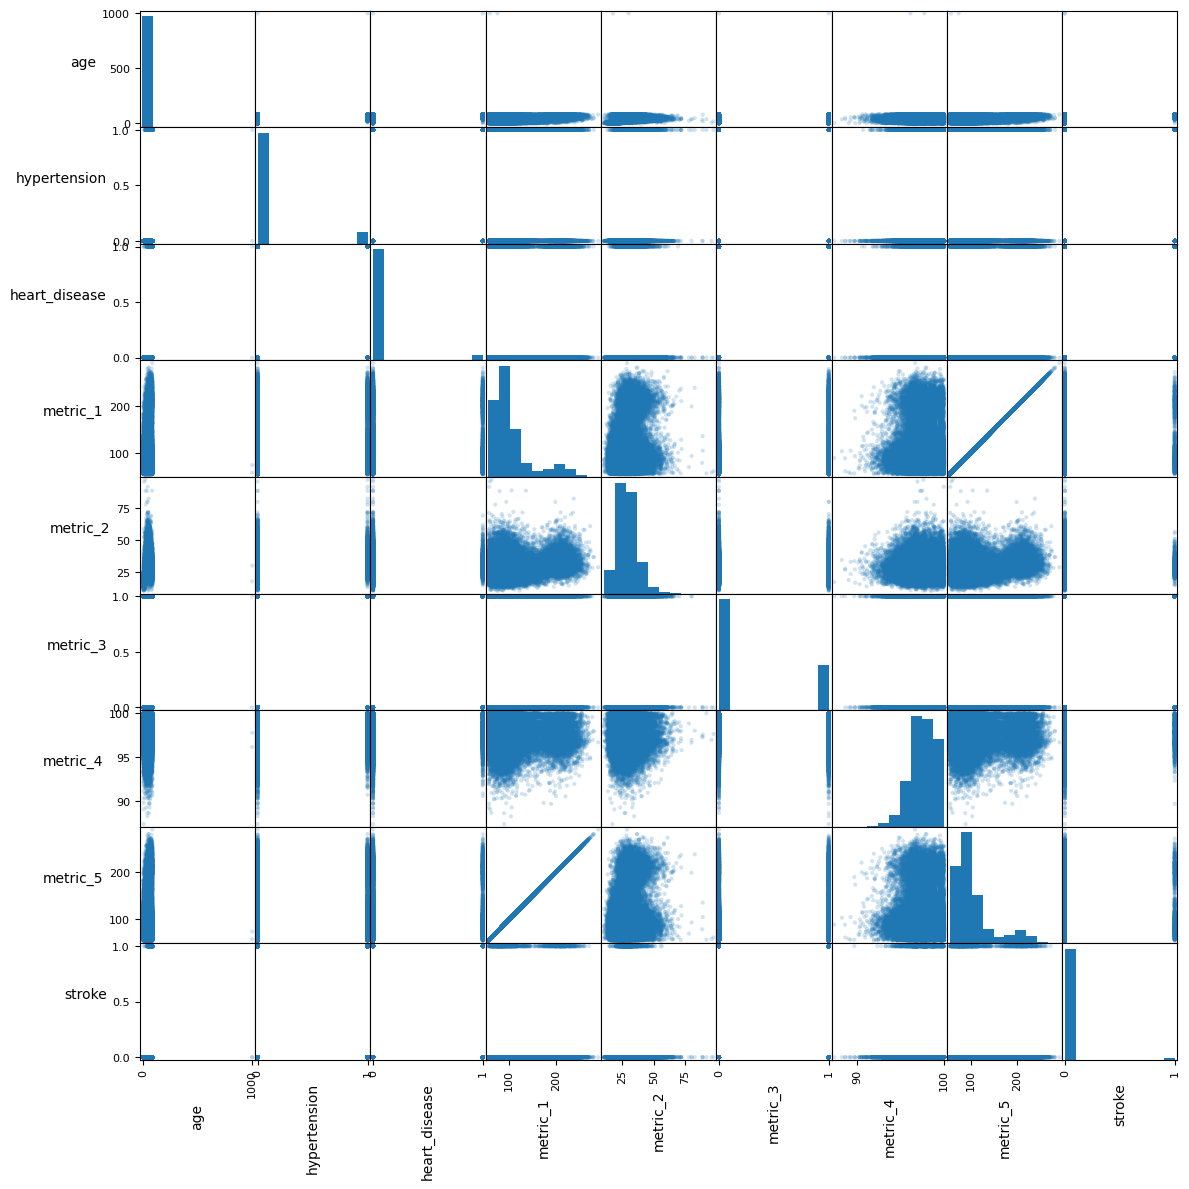

In [67]:
df2 = df.loc[:, df.columns != 'id']
axes = pd.plotting.scatter_matrix(df2, figsize=(12, 12), alpha=0.2)

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

At a glance, we can tell that this dataset is imbalanced, and may have dirty data:
1. It is strange that the scale of the x-axis of the age-age plot (histogram of ages) is so wide; probably means there is a person recorded with extremely high age
2. In stroke-stroke plot (histogram of stroke frequency), a much higher proportion of responders reported not having a stroke (0), than stroke (1).

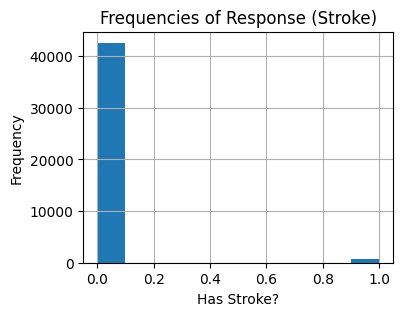

783 responders have had a stroke


In [68]:
# Looking further into stroke frequency plot:
df['stroke'].hist(figsize=(4,3))
plt.title("Frequencies of Response (Stroke)")
plt.xlabel("Has Stroke?")
plt.ylabel("Frequency")
plt.show()
# How many people reported 1 (had stroke)?
print((df['stroke'] == 1).sum(), 'responders have had a stroke')

^ Based on the above plot, the dataset appears unbalanced, because most responders did not have a stroke.
We may consider doing undersampling, because the majority class (0) is overwhelmingly large. Also, 783 of responders did have a stroke, which is still a large enough size to work with, so we don't need to worry much about lack of data.

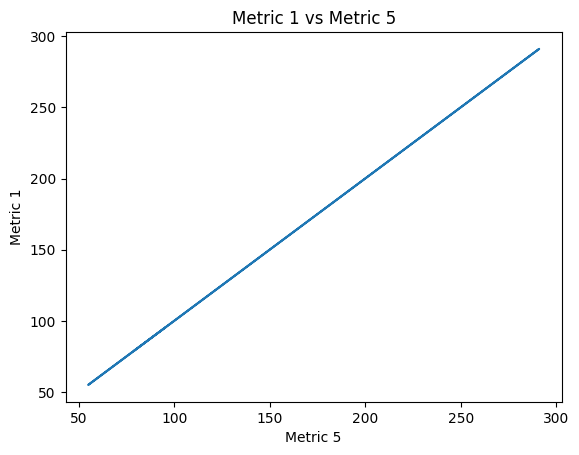

0 rows where metric 1 differs from 5


In [69]:
# Looking at metric 1 and 5 plot (very linearly correlated)
plt.plot(df['metric_5'], df['metric_1'])
plt.title("Metric 1 vs Metric 5")
plt.xlabel("Metric 5")
plt.ylabel("Metric 1")
plt.show()

# Metric 1 values are the same as metric 5 values
# Find rows where metric 1 isn't equal to metric 5
print(len(df[df['metric_1'] != df['metric_5']]), 'rows where metric 1 differs from 5')

# Drop metric 5
df=df.drop(['metric_5'], axis=1)

Metrics 1 and 5 are highly linearly correlated, which may cause multicollinearity issues in our model(s).
Because these 2 predictors are identical/redundant, we can drop 1 of these 2 predictors.

(Otherwise, if the columns were highly linearly correlated but not identical:
Only these 2 variables are multicollinear; if there were many more multicollinear features, we may attempt best subsets regression to choose best predictors. If we choose a linear model, we may do partial F test to see if excluding a predictor has significant effect on response.)

### Data Cleaning, Feature Engineering

Remove unreasonable age numbers

0.013880140900926121 of entire dataset is removed if we drop non-int ages


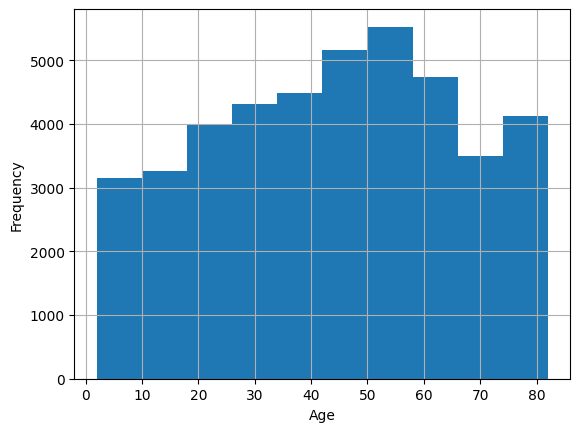

In [70]:
# Remove unreasonable age numbers
# For simplicity, rows are dropped bc there are not too many dirty ages

# max(df['age']) # Found a person with age 1000
df = df[(df['age'] < 200) & (df['age'] > 1)]

# Dropped non-integer ages
# df['age'].unique() # Found non-integer ages
non_int_ages = len(df[~df['age'].map(lambda x: x.is_integer())])
total_data = len(df)
print(non_int_ages/total_data, 'of entire dataset is removed if we drop non-int ages')
df = df[df['age'].map(lambda x: x.is_integer())] # Drop non-int ages

# Check balance of ages
df['age'].hist() # Distribution balance seems fine
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Convert categorical data into dummy/indicator variables

In [71]:
# Categorical into dummy/indicator vars
for cat in ['gender', 'married', 'occupation', 'residence']:
    dummy = pd.get_dummies(df[cat])
    df = df.join(dummy)
    df.drop([cat], axis=1, inplace=True)
# Renamed columns corresponding to occupation, married. Should do this for other columns later
df.rename(columns = {'Male': 'gender_Male',
                     'Female': 'gender_Female',
                     'Other': 'gender_Other'}, inplace=True)
df.rename(columns = {'Rural': 'residence_Rural',
                     'Urban': 'residence_Urban'}, inplace=True)
df.rename(columns = {'A': 'occupation_A',
                     'B': 'occupation_B',
                     'C': 'occupation_C',
                     'D': 'occupation_D',
                     'E': 'occupation_E'}, inplace=True)
df.rename(columns = {'Yes': 'married_Yes',
                     'No':'married_No'}, inplace=True)
df.head()
# Chose to turn smoking_status into single numerical variable; if we only convert to indicator variables, like above,
# we'd ignore natural ordering of 'smokes' , 'formerly smoked', 'never smoked'

# Several categorical predictors -> Regression and classification trees are good at handling

,id,age,hypertension,heart_disease,metric_1,metric_2,metric_3,metric_4,smoking_status,stroke,...,gender_Other,married_No,married_Yes,occupation_A,occupation_B,occupation_C,occupation_D,occupation_E,residence_Rural,residence_Urban
0,1,3.0,0,0,95.12,18.0,1,99.35,NaN,0,...,0,1,0,1,0,0,0,0,1,0
1,2,58.0,1,0,87.96,39.2,1,99.70,never smoked,0,...,0,0,1,0,1,0,0,0,0,1
2,3,8.0,0,0,110.89,17.6,0,96.35,NaN,0,...,0,1,0,0,1,0,0,0,0,1
3,4,70.0,0,0,69.04,35.9,0,95.52,formerly smoked,0,...,0,0,1,0,1,0,0,0,1,0
4,5,14.0,0,0,161.28,19.1,1,95.10,NaN,0,...,0,1,0,0,0,1,0,0,1,0


Dealing with smoking_status column: missing 30% of values, and converting to numerical

Convert ordinal categorical var (smoking_status) into numerical scale

In [72]:
# Convert ordinal categorical variable into numerical scale
# 'smokes' = 2, 'formerly smoked' = 1, 'never smoked' = 0
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(categories=[['never smoked', 'formerly smoked','smokes']], handle_unknown='use_encoded_value', unknown_value=np.nan)
encoder.fit([['smokes'], ['formerly smoked'],  ['never smoked']])
res = encoder.transform(df.loc[:, ['smoking_status']].values)
df['smoking_status'] = res
df.head()

,id,age,hypertension,heart_disease,metric_1,metric_2,metric_3,metric_4,smoking_status,stroke,...,gender_Other,married_No,married_Yes,occupation_A,occupation_B,occupation_C,occupation_D,occupation_E,residence_Rural,residence_Urban
0,1,3.0,0,0,95.12,18.0,1,99.35,NaN,0,...,0,1,0,1,0,0,0,0,1,0
1,2,58.0,1,0,87.96,39.2,1,99.70,0.0,0,...,0,0,1,0,1,0,0,0,0,1
2,3,8.0,0,0,110.89,17.6,0,96.35,NaN,0,...,0,1,0,0,1,0,0,0,0,1
3,4,70.0,0,0,69.04,35.9,0,95.52,1.0,0,...,0,0,1,0,1,0,0,0,1,0
4,5,14.0,0,0,161.28,19.1,1,95.10,NaN,0,...,0,1,0,0,0,1,0,0,1,0


In [73]:
# df.smoking_status.info()
print(df.smoking_status.isnull().sum(), 'ppl missing smoking_status') 
print(len(df.smoking_status), 'total ppl in dataset')
# df.smoking_status.hist()
# plt.show()

# How to impute missing categorical data?
# Choose random values, but probabilistically? (some will not make sense, e.g. 1-3 year olds probably don't smoke)
# K nearest neighbors? Cons: slow, cannot guarantee accuracy
# Will try KNN imputation here:

# Normalize data before using KNN, bc KNN sensitive to different number scales
scaler = MinMaxScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df.drop(labels='id', axis=1, inplace=True)
cols = df.columns[(df.columns != 'smoking_status')]
# df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.loc[:, (df.columns != 'id')&(df.columns != 'smoking_status')].columns)
# df.loc[:, df.columns != col]
# df_scaled = df.drop(['id', 'smoking_status'], axis=1)
# df_scaled = scaler.fit_transform(df_scaled)


df[cols] = scaler.fit_transform(df[cols])

imputer = KNNImputer(n_neighbors=5) # Use 5 nearest neighbors
df['smoking_status'] = imputer.fit_transform(df[['smoking_status']]).round() # round to nearest int

12166 ppl missing smoking_status
42272 total ppl in dataset


A significant amount of people are missing smoking_status, so it is better to impute values than drop. I used KNN to impute missing values above, but there are other ways to impute them too. I could have chosen to use the mode to impute them, but I thought that the mode of smoking status might not be too reasonable, because I did not want 30% of all statuses to be the same value. I could also have chosen to impute using random values, or random values but preserving the proportion of the different statuses. But, for convenience, I chose to do KNN imputation because it was an already-existing function in sklearn. If I had more time, I would explore these other imputation methods.

In [74]:
# Drop other rows with NaNs (only ~1000 of them)
# There are better, more selective ways to remove the nulls, but I just did this because there are a relatively small number of them
df = df[~df.isnull().any(axis=1)] 

# If had more time , then I would consider imputing

df.head()
# df.info()

,age,hypertension,heart_disease,metric_1,metric_2,metric_3,metric_4,smoking_status,stroke,gender_Female,...,gender_Other,married_No,married_Yes,occupation_A,occupation_B,occupation_C,occupation_D,occupation_E,residence_Rural,residence_Urban
0,0.0125,0.0,0.0,0.169964,0.090286,1.0,0.944492,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.7000,1.0,0.0,0.139631,0.332571,1.0,0.974381,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0750,0.0,0.0,0.236772,0.085714,0.0,0.688301,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.8500,0.0,0.0,0.059479,0.294857,0.0,0.617421,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.1500,0.0,0.0,0.450244,0.102857,1.0,0.581554,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### Models

#### GLM (logistic regression)

FIRST: narrow down features

In [75]:
endog = df['stroke'] # Response variable, y
exog = df.drop('stroke', axis=1) # X
# Undersampling
rus = RandomUnderSampler(random_state = 1)
X_new, y_new = rus.fit_resample(exog, endog)

# Use logit (logistic) link function, bc response is binary. Logistic maps numbers to range [0,1]
fam = sm.families.Binomial(link=sm.families.links.logit())
glm = sm.GLM(y_new, X_new, family=fam)
glm1_res = glm.fit()
print(glm1_res.summary())
# formula = 'stroke ~' + ' + '.join(df.columns.drop('stroke'))
# glm = sm.formula.glm(formula = formula, data=df, family = sm.families.Gaussian())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 stroke   No. Observations:                 1286
Model:                            GLM   Df Residuals:                     1270
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sat, 08 Apr 2023   Deviance:                       1211.6
Time:                        22:12:39   Pearson chi2:                 1.24e+03
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
age                 5.8225      0.433     

c:\Users\carol\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\carol\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\carol\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


Above fits model to all the features to an undersampled dataset. The P>|z| column represents the p-value corresponding to the null hypothesis that a predictor has statistically significant relationship with the response. Most values in this column are less than 0.05, suggesting that most of the predictors have a statistically significant relationship with the response variable (except metrics 2, 3, 4).

However, including all of these predictors puts our model at risk of overfitting, so we will try to narrow down the most important features.

GLM for binary response equates to logistic regression. For convenience, I switch to using the sklearn library so I can use its stepwise feature selector, and easily do cross validation on my GLM (logistic regression) models.

In [76]:
# Note: GLM for binary response equates to just doing logistic regression

# Select most important features:
# Create log reg obj
lr1 = LogisticRegression()
lr2 = LogisticRegression()

# Create forward or backward stepwise selector
selector1 = SequentialFeatureSelector(lr1, scoring= 'recall', direction='backward', cv=5, n_features_to_select='auto',tol=-.001)
selector2 = SequentialFeatureSelector(lr2, scoring= 'f1', direction='backward', cv=5, n_features_to_select='auto',tol=-.001)
# Fit selector
selector1.fit(X_new, y_new)
selector2.fit(X_new, y_new)
# Get feature names
selected_features1 = selector1.get_feature_names_out()
selected_features2 = selector2.get_feature_names_out()
print('Best features by recall: ',selected_features1)
print('Best features by F1: ',selected_features2)

Best features by recall:  ['age' 'metric_1' 'metric_3' 'smoking_status' 'married_Yes'
 'residence_Rural' 'residence_Urban']
Best features by F1:  ['age' 'hypertension' 'metric_1' 'metric_3' 'smoking_status'
 'occupation_B' 'occupation_D' 'residence_Urban']


Above, I prioritize high recall over high precision, because we would want to minimize false negatives. We prefer to have a model that is more likely to predict stroke when patient will not have it, than to have a model that predicts no stroke when patient will have it.
For reference, I also optimize for F1 score.

There are other ways to try to narrow down best features, for example best subsets feature selection, but it is computationally expensive. 
I also could try to find the most correlated features (using Spearman or Pearson correlation coefficients), but when I tried it, it does not increase any of our performance metrics significantly. I believe Ridge and Lasso regression are also options, but I did not have time to explore them.

In [79]:
# Datasets with selected features
X_new1 = X_new[selected_features1] # only use features optimized for recall
X_new2 = X_new[selected_features2] # only use features optimized for f1

# Commented out: top 10 correlated features using pearson/spearman coefficients
# pearson = df.corr('pearson')[['stroke']].sort_values(by='stroke', ascending=False)
# spearman = df.corr('spearman')[['stroke']].sort_values(by='stroke', ascending=False)
# print(f"Pearson:\n{pearson[1:10]}")
# print(f"Spearman:\n{spearman[1:10]}")
# X_new3 = X_new[['age','heart_disease','hypertension', 'metric_1', 'Yes', 'occupation_D']] # top 6 correlated predictors

# compute_scores(model, predictors, response) -> None. 
# Prints out recall, F1, and accuracy scores for the model.
def compute_scores(lr, X, y):
      scores_recall = cross_val_score(lr, X, y, cv=5, scoring='recall')
      scores_f1 = cross_val_score(lr, X, y, cv=5, scoring='f1')
      scores_a = cross_val_score(lr, X, y, cv=5, scoring='accuracy')
      print('Recall: ', scores_recall.mean(), ', F1: ', scores_f1.mean(), ', Accuracy:', scores_a.mean())

print('Feature set 1 (optimized for recall): ')
compute_scores(lr1, X_new1, y_new)
print('Feature set 2 (optimized for F1): ')
compute_scores(lr2, X_new2, y_new)
# print('Feature set 3 (top 6 correlated features): ')
# compute_scores(lr3, X_new3, y_new)
lr4 = LogisticRegression() # Print out regression using all features, for reference
print('All features: ')
compute_scores(lr4, X_new, y_new)

Feature set 1 (optimized for recall): 
Recall:  0.8227107558139535 , F1:  0.7807352786976934 , Accuracy: 0.7690525744276535
Feature set 2 (optimized for F1): 
Recall:  0.8118217054263566 , F1:  0.780243900145136 , Accuracy: 0.7713932374144119
All features: 
Recall:  0.7978197674418606 , F1:  0.772413550771822 , Accuracy: 0.7651735891171236


These metrics do not vary too wildly from each other. So, if we prefer the simplest model, we would pick the first model, which was optimized for recall. 

(Its features were ['age' 'metric_1' 'metric_3' 'smoking_status' 'Yes' 'Rural' 'Urban'].)

In [78]:
# Printing out GLM coefficients for reference
lr1.fit(X_new1, y_new)
lr2.fit(X_new2, y_new)
print("Coeffs for model 1 (recall optimized):\n", lr1.coef_)
print("Coeffs for model 2 (F1 optimized):\n", lr2.coef_)

Coeffs for model 1 (recall optimized):
 [[ 5.42230005  1.65981028 -0.09788619  0.1413974   0.06219177 -0.1385186
   0.13864866]]
Coeffs for model 2 (F1 optimized):
 [[ 5.29294716  0.55800537  1.60867963 -0.12013903  0.15143179  0.37849824
   0.30572715  0.26029003]]


Additional Parameter tuning for GLM (logistic regression)

In [108]:
# Finding Best Parameters

# tune(model, params:dict, predictors, response) -> None. 
# After tuning paramteres, prints out recall, F1, and accuracy scores for the model.
def tune(model, params, X, y, scoring):
    model_clf = GridSearchCV(model(), param_grid=params, cv=5, scoring=scoring)
    model_clf.fit(X, y)
    model_best_params = model_clf.best_params_

    # Calculating Performance
    model_best = model(**model_best_params)
    model_best.fit(X, y)
    print('Best parameters: ',model_best_params)
    compute_scores(model_best, X, y)

# Parameters
params = {'solver': ['liblinear', 'saga'], 'penalty':['l1','l2']}
tune(LogisticRegression, params, X_new1, y_new, 'recall') # Features optimized for recall
tune(LogisticRegression, params, X_new1, y_new, 'f1') # Features optimized for recall
tune(LogisticRegression, params, X_new2, y_new, 'recall') # Features optimized for f1
tune(LogisticRegression, params, X_new2, y_new, 'f1') # Features optimized for f1

Best parameters:  {'penalty': 'l1', 'solver': 'saga'}
Recall:  0.8117853682170543 , F1:  0.7776827741005315 , Accuracy: 0.7682864295840497
Best parameters:  {'penalty': 'l1', 'solver': 'saga'}
Recall:  0.8117853682170543 , F1:  0.7776827741005315 , Accuracy: 0.7682864295840497
Best parameters:  {'penalty': 'l1', 'solver': 'liblinear'}
Recall:  0.8071463178294573 , F1:  0.7739571341307658 , Accuracy: 0.7643893463638283
Best parameters:  {'penalty': 'l1', 'solver': 'liblinear'}
Recall:  0.8071463178294573 , F1:  0.7739571341307658 , Accuracy: 0.7643893463638283


Parameter tuning did not significantly improve the performance metrics much.

#### Classification Tree attempt

In [109]:
# Note: X_new, y_new are predictors and response, as defined above. 
# Repeat similar process:

# Select most important features:
# Create tree obj
tree1 = tree.DecisionTreeClassifier()
tree2 = tree.DecisionTreeClassifier()
tree3 = tree.DecisionTreeClassifier() # Print out tree using all features, for reference

# Create forward or backward stepwise selector
selector1 = SequentialFeatureSelector(tree1, scoring= 'recall', direction='backward', cv=5, n_features_to_select='auto',tol=-.01)
selector2 = SequentialFeatureSelector(tree2, scoring= 'f1', direction='backward', cv=5, n_features_to_select='auto',tol=-.01)

# Fit selector
selector1.fit(X_new, y_new)
selector2.fit(X_new, y_new)
# Get feature names
selected_features1 = selector1.get_feature_names_out()
selected_features2 = selector2.get_feature_names_out()
print('Best features by recall: ',selected_features1)
print('Best features by F1: ',selected_features2)

# Datasets with selected features
X_new1 = X_new[selected_features1] # only use features optimized for recall
X_new2 = X_new[selected_features2] # only use features optimized for f1

print('Feature set 1 (optimized for recall): ')
compute_scores(tree1, X_new1, y_new)
print('Feature set 2 (optimized for F1): ')
compute_scores(tree2, X_new2, y_new)
print('All features: ')
compute_scores(tree3, X_new, y_new)

Best features by recall:  ['age' 'hypertension' 'metric_1' 'metric_2' 'metric_3' 'metric_4'
 'smoking_status' 'gender_Female' 'gender_Male' 'gender_Other'
 'married_No' 'occupation_A' 'residence_Rural' 'residence_Urban']
Best features by F1:  ['age' 'metric_1' 'metric_2' 'metric_4' 'smoking_status' 'occupation_A']
Feature set 1 (optimized for recall): 
Recall:  0.7060925387596899 , F1:  0.6916926079082806 , Accuracy: 0.6850420776400326
Feature set 2 (optimized for F1): 
Recall:  0.6795300387596899 , F1:  0.6794465768364257 , Accuracy: 0.6702711670135433
All features: 
Recall:  0.679578488372093 , F1:  0.6750797621496043 , Accuracy: 0.6772629927909992


Parameter Tuning

In [110]:
params = {'criterion' : ["entropy"], 
          'min_samples_split': [i for i in range(30, 70, 10)], 
          'min_samples_leaf': [i for i in range(2,6,1)], 
          'max_depth': [i for i in range(12,17,1)]}
tune(tree.DecisionTreeClassifier, params, X_new1, y_new, 'recall') # Features optimized for recall
tune(tree.DecisionTreeClassifier, params, X_new1, y_new, 'f1') # Features optimized for recall
tune(tree.DecisionTreeClassifier, params, X_new2, y_new, 'recall') # Features optimized for f1
tune(tree.DecisionTreeClassifier, params, X_new2, y_new, 'f1') # Features optimized for f1
tune(tree.DecisionTreeClassifier, params, X_new, y_new, 'recall') # All features
tune(tree.DecisionTreeClassifier, params, X_new, y_new, 'f1') # All features

Best parameters:  {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 50}
Recall:  0.7463905038759691 , F1:  0.7246836859137268 , Accuracy: 0.7161312701716286
Best parameters:  {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 50}
Recall:  0.7417635658914729 , F1:  0.727079346452607 , Accuracy: 0.7200404186649776
Best parameters:  {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 50}
Recall:  0.7385901162790698 , F1:  0.7212025333921304 , Accuracy: 0.7153590926914608
Best parameters:  {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 60}
Recall:  0.7339874031007751 , F1:  0.7260170261923519 , Accuracy: 0.7231351612222122
Best parameters:  {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 50}
Recall:  0.7635416666666667 , F1:  0.7392338554844834 , Accuracy: 0.7301360359545139
Best parameters:  {'criterion': 'ent

These trees still can't beat the scores of GLM. Try ensemble methods?

#### Ensemble Methods attempt

In [111]:
method = [RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier]
for m in method:
    compute_scores(m(), X_new, y_new)

Recall:  0.7838057170542636 , F1:  0.7751268181662121 , Accuracy: 0.7605103610532983
Recall:  0.8024588178294574 , F1:  0.7730249825980993 , Accuracy: 0.7643772810907007
Recall:  0.7930595930232559 , F1:  0.7599181190931942 , Accuracy: 0.7496093867824933


None of these beat the GLM performance. Try AdaBoost, but using the best tree from above as a base classifier?

In [119]:
# Adaboost using best tree
base = tree.DecisionTreeClassifier(**{'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 50})
ab = AdaBoostClassifier(estimator=base)
compute_scores(ab, X_new, y_new)

Recall:  0.724781976744186 , F1:  0.7192738880666896 , Accuracy: 0.7177269025427563


Still doesn't beat GLM performance. Gradient Boosting resulted in the highest recall, so I will parameter tune it:

In [120]:
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.5, 0.75, 1.0]
}

tune(GradientBoostingClassifier, params, X_new, y_new, 'recall')

Best parameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
Recall:  0.8242853682170542 , F1:  0.7831387714570781 , Accuracy: 0.770624076252526


In [121]:
# Best model from gradient boosting
best_gradient = GradientBoostingClassifier(**{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5})
compute_scores(best_gradient, X_new, y_new)

Recall:  0.827374031007752 , F1:  0.7711633176002878 , Accuracy: 0.7675021868307543


Best Scores for Model 1 from GLM (optimized for recall):

Recall:  0.8227107558139535 , F1:  0.7807352786976934 , Accuracy: 0.7690525744276535

Coefficients: [[ 5.42230005  1.65981028 -0.09788619  0.1413974   0.06219177 -0.1385186
   0.13864866]]


Best scores for Gradient Boosting classifier (optimized for recall):

Recall:  0.827374031007752 , F1:  0.7711633176002878 , Accuracy: 0.7675021868307543

Technically the recall in the Gradient Boosting model is higher, but the difference is not much.

Ensemble methods usually have improved accuracy because they incorporate multiple smaller models, and are generally less affected by outliers. However, they can still suffer from overfitting if the smaller models can overfit. In this case, I would still prefer the GLM (logistic regression) model, because it is  relatively simple, and not as time consuming in terms of parameter tuning compared to the gradient boosting model. 

There are definitely other machine learning models that I could have tried, but did not attempt due to time.